In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam, SGD, Adadelta
from keras.callbacks import EarlyStopping

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

<AxesSubplot:>

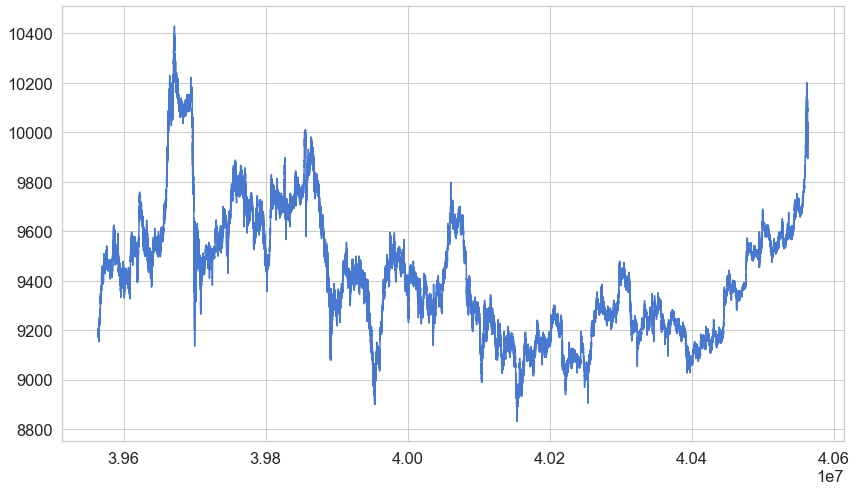

In [8]:
pd.options.display.float_format = '{:.5f}'.format
df = pd.read_csv("../data/bitstampUSD.csv", names=['time', 'price', 'volume'])
df['pct_price'] = df.price.pct_change()
# df['timediff'] = df.time.diff()
df = df[-1000000:]
df.price.plot()

In [9]:
df.dropna(inplace=True)
print(df.head())
print(df.describe())
print(df.isnull().sum())
prices = df.price.values

                time      price  volume  pct_price
39563719  1590655972 9173.51000 0.43616    0.00002
39563720  1590656008 9174.93000 0.00967    0.00015
39563721  1590656008 9175.20000 0.01208    0.00003
39563722  1590656016 9177.13000 0.01000    0.00021
39563723  1590656016 9178.49000 0.54310    0.00015
                  time         price        volume     pct_price
count    1000000.00000 1000000.00000 1000000.00000 1000000.00000
mean  1592985772.80908    9425.75134       0.35378       0.00000
std      1569265.46198     257.81535       1.31521       0.00033
min   1590655972.00000    8830.63000       0.00000      -0.02586
25%   1591594369.75000    9222.07000       0.01000      -0.00002
50%   1592874534.00000    9404.50000       0.03766       0.00000
75%   1594306587.00000    9583.07250       0.31213       0.00003
max   1595758548.00000   10429.26000     184.79255       0.02236
time         0
price        0
volume       0
pct_price    0
dtype: int64


In [10]:
scaler = MinMaxScaler()
r_prices = prices.reshape(-1, 1)
scaled_prices = scaler.fit_transform(r_prices)
scaled_prices = scaled_prices[~np.isnan(scaled_prices)]
scaled_prices = scaled_prices.reshape(-1, 1)

In [11]:
SEQ_LEN = 64

def to_sequences(scaled_data, seq_len):
    x = []
    y = []
    for idx, data in enumerate(scaled_data):
        if idx <= scaled_data.shape[0] - seq_len - 1:
            tmpx = []
            tmpy = []
            for r in range(seq_len + 1):
                if r < seq_len:
                    tmpx.append(scaled_data[idx+r])
                else:
                    tmpy.append(scaled_data[idx+r][0])
            if len(tmpx) == seq_len:
                x.append(tmpx)
                y.append(tmpy)
    return np.asarray(x, dtype=np.float64), np.asarray(y, dtype=np.float64)

In [12]:
'''''
test = np.arange(0, 100, 0.1)
test = np.sin(test)
scaler2 = MinMaxScaler()
test = test.reshape(-1, 1)
scaled_test = scaler.fit_transform(test)
scaled_test = scaled_test[~np.isnan(scaled_test)]
scaled_test = scaled_test.reshape(-1, 1)
train_test = scaled_test[0:scaled_test.shape[0]-100]
X, Y = to_sequences(train_test, SEQ_LEN)
X_val, Y_val = to_sequences(scaled_test[-100:], SEQ_LEN)
'''''
train_test = scaled_prices[0:scaled_prices.shape[0]-1024]
X, Y = to_sequences(train_test, SEQ_LEN)
X_val, Y_val = to_sequences(scaled_prices[-1024:], SEQ_LEN)

#for idx, n in enumerate(X):
#    print(X[idx], Y[idx])


In [13]:
print(X.shape)
print(Y.shape)
print(X_val.shape)
print(Y_val.shape)
#plt.plot(test)

(998912, 64, 1)
(998912, 1)
(960, 64, 1)
(960, 1)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(899020, 64, 1)
(99892, 64, 1)
(899020, 1)
(99892, 1)


In [21]:
DROPOUT = 0
WINDOW_SIZE = SEQ_LEN

model = Sequential()
model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Activation('relu'))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  LSTM((WINDOW_SIZE*2), return_sequences=True)
))
model.add(Activation('relu'))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  LSTM((WINDOW_SIZE*2), return_sequences=False)
))
model.add(Activation('relu'))
model.add(Dropout(rate=DROPOUT))
model.add(Dense(units=1))
model.add(Activation('relu'))


In [24]:
BATCH_SIZE = 32
model.compile(
    loss='mean_squared_error',
    optimizer='Adadelta'
)
my_callbacks = [
    EarlyStopping(patience=6)
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')
]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 64, 128)           33792     
_________________________________________________________________
activation_14 (Activation)   (None, 64, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 64, 256)           263168    
_________________________________________________________________
activation_15 (Activation)   (None, 64, 256)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 256)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               394240    
__________

In [25]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.5,
    verbose=1,
    callbacks=my_callbacks
)

Train on 449510 samples, validate on 449510 samples
Epoch 1/100
INFO:plaidml:Analyzing Ops: 2928 of 37892 operations complete
INFO:plaidml:Analyzing Ops: 8464 of 37892 operations complete
INFO:plaidml:Analyzing Ops: 14210 of 37892 operations complete
INFO:plaidml:Analyzing Ops: 20918 of 37892 operations complete
INFO:plaidml:Analyzing Ops: 27423 of 37892 operations complete
INFO:plaidml:Analyzing Ops: 32685 of 37892 operations complete
INFO:plaidml:Analyzing Ops: 36892 of 37892 operations complete
 29952/449510 [>.............................] - ETA: 1:09:06 - loss: 4.3270e-04

KeyboardInterrupt: 

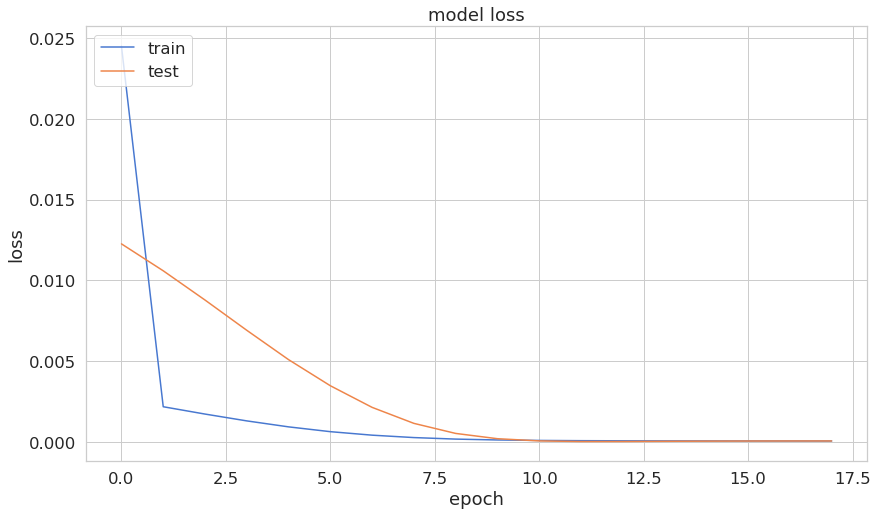

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

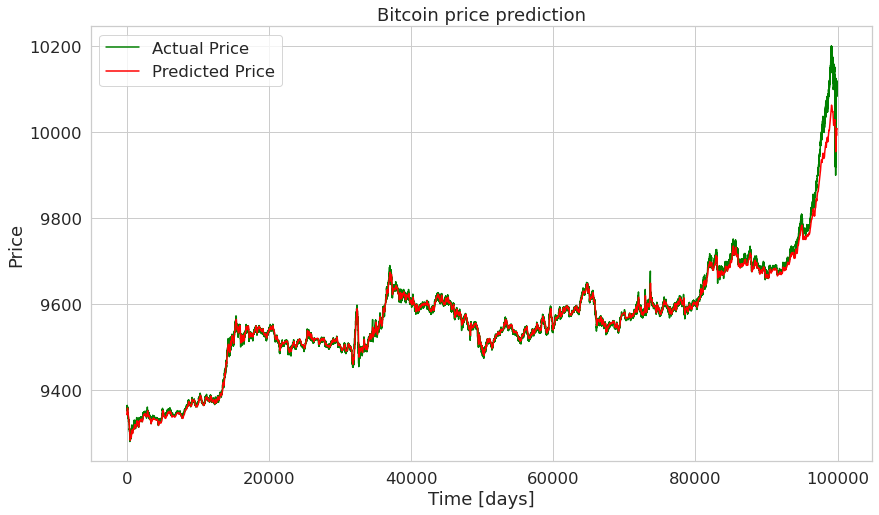

In [13]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show();

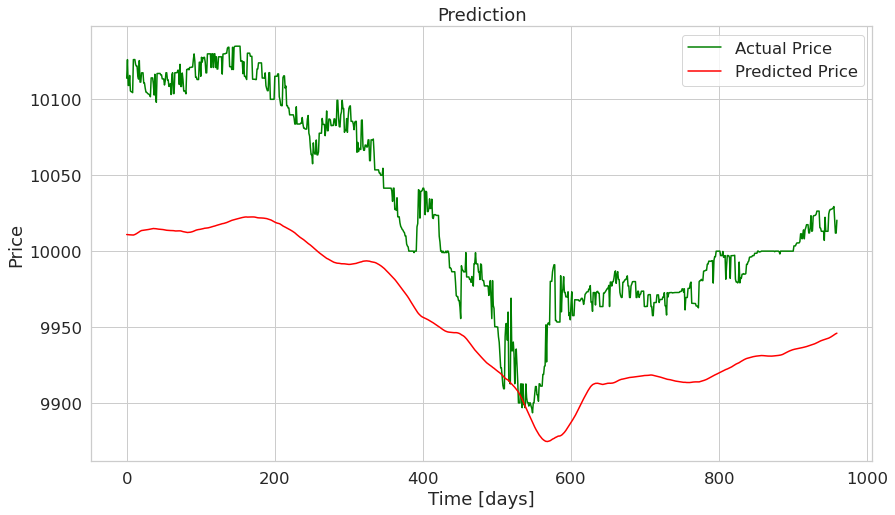

In [14]:
y_hat2 = model.predict(X_val)
y_test_inverse2 = scaler.inverse_transform(Y_val)
y_hat_inverse2 = scaler.inverse_transform(y_hat2)
 
plt.plot(y_test_inverse2, label="Actual Price", color='green')
plt.plot(y_hat_inverse2, label="Predicted Price", color='red')
 
plt.title('Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show();

In [16]:
model.save('models/m64x2x2d0')

INFO:tensorflow:Assets written to: models/m64x2x2d0/assets
